# Visualisations for presentation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./shapley_compute/')

In [2]:
from shapley_compute.simulations.regressions import normal_linear_model, correlated_features_regression
from shapley_compute.ensembled_mp import mp_shapley, loco_error
from shapley_compute.minipatches import minipatch_regression, get_minipatch
from shapley_compute.locomp import LOCOMPReg, LOCOMP_random

In [3]:
from sklearn.linear_model import Lasso, RidgeCV, LinearRegression

# Feature importance scores

## Linear normal model

In [14]:
M = 20 # features
N = 1000 # observations
rho = 0.8
s = 0.5
SNR = 2
y, X, beta = normal_linear_model(N, M, s=s, SNR=SNR)  # N, M, SNR = 10, sigma2=0.4, s=0.2

<BarContainer object of 20 artists>

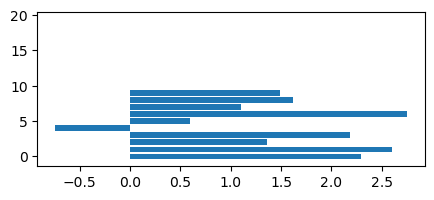

In [15]:
plt.figure(figsize=(5,2))
plt.barh([i for i in range(M)], beta)

100%|██████████| 1000/1000 [00:13<00:00, 75.74it/s]


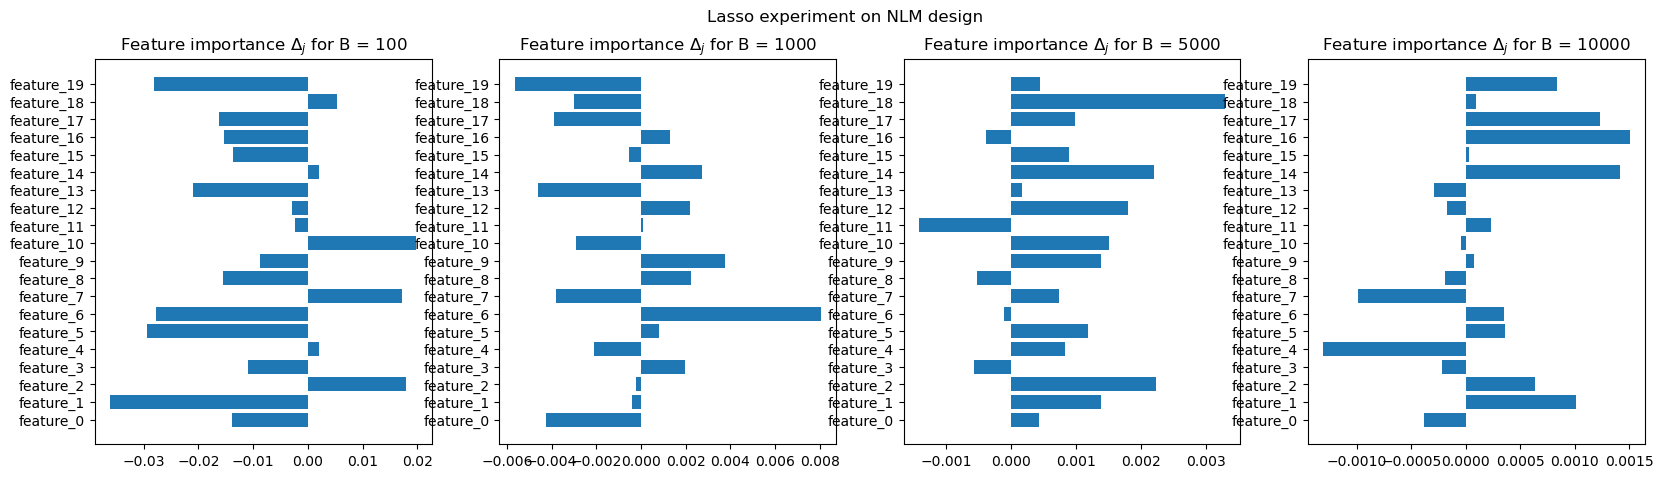

In [16]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    Delta = loco_error(X,y, model, x_ratio,list_B[b])
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.suptitle('Lasso experiment on NLM design')
plt.savefig('./figures/NLM_mine_locomp_Lasso_SNR{}.svg'.format(SNR))

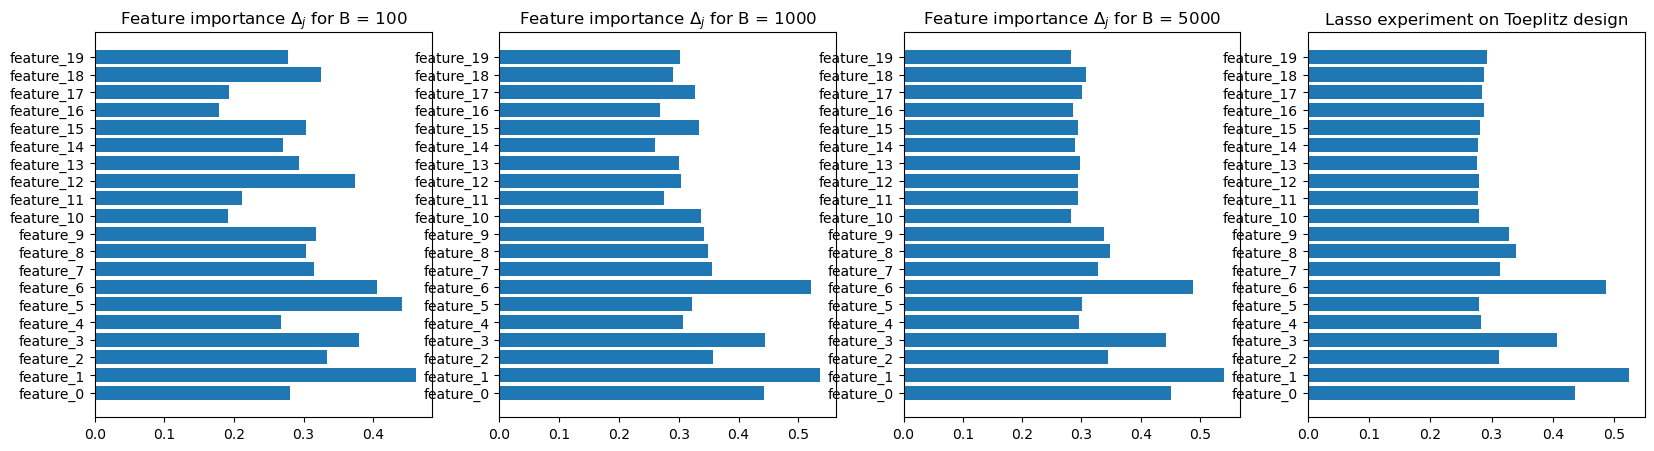

In [17]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_locomp_Lasso_SNR{}.svg'.format(SNR))

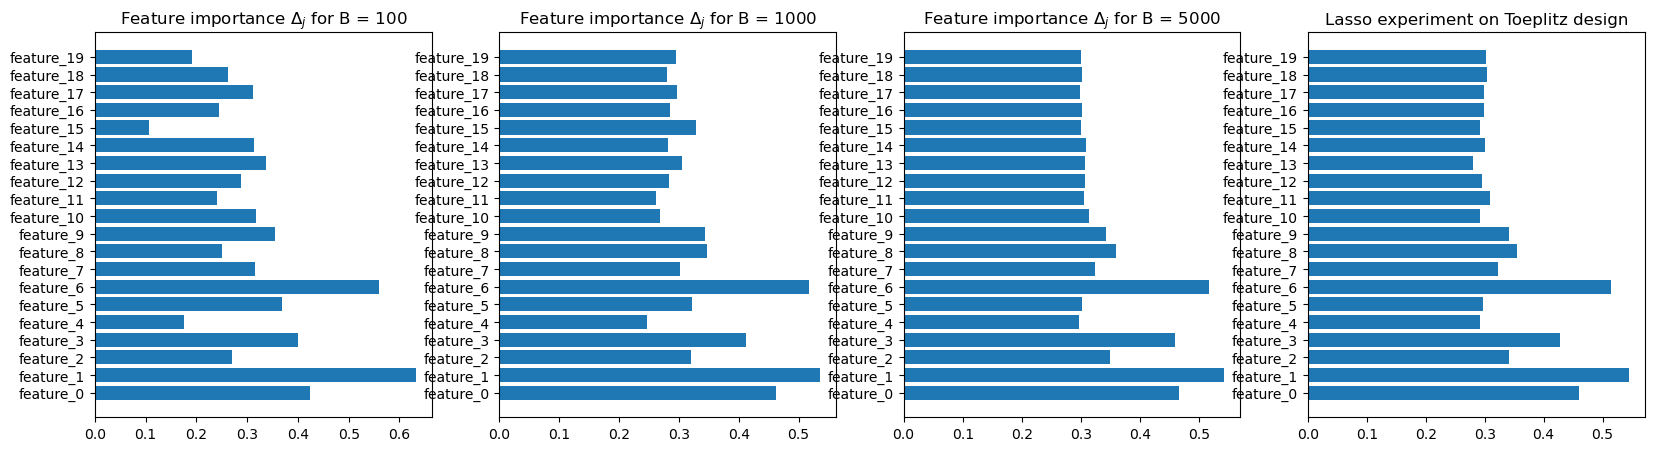

In [21]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.5
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_locomp_Lasso_SNR{}.svg'.format(SNR))

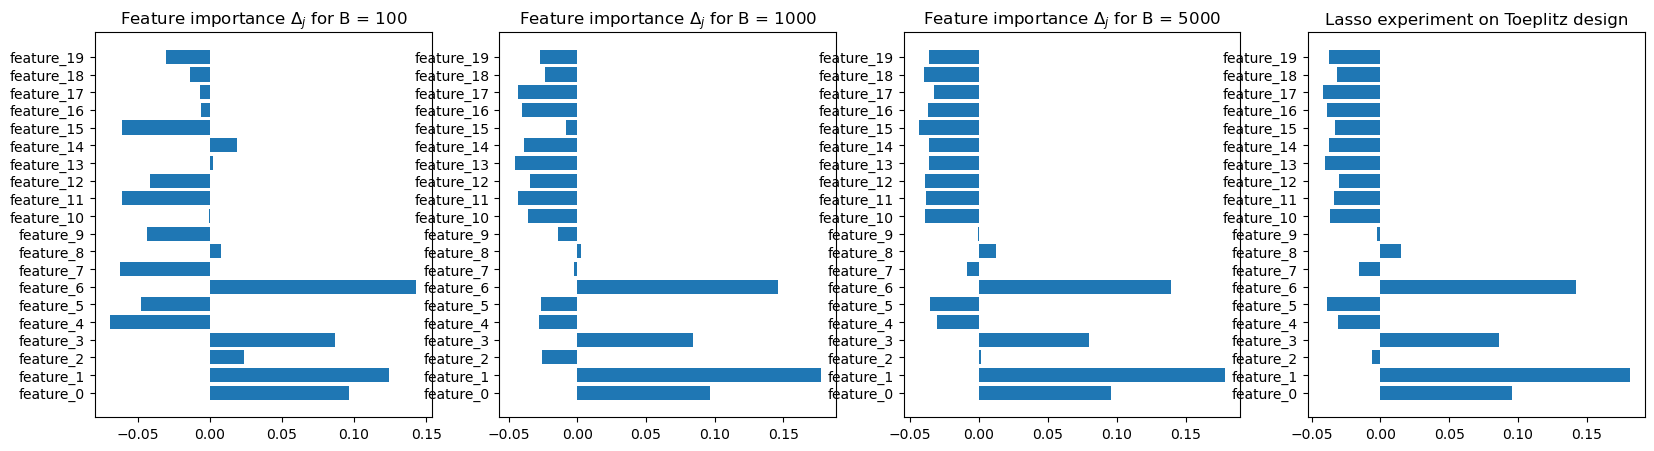

In [18]:
list_B = [100, 1000, 5000, 10000]
n_ratio = 0.2
m_ratio = 0.3
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMPReg(X,y,n_ratio, m_ratio,list_B[b], model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_og_locomp_Lasso_SNR{}.svg'.format(SNR))

## Toeplitz design

In [4]:
M = 20 # features
N = 1000 # observations
rho = 0.8
s = 0.5
SNR = 2
y, X, beta = correlated_features_regression(N, M, s=s, SNR=SNR, type='toeplitz') #toeplitz or equi-corr

<BarContainer object of 20 artists>

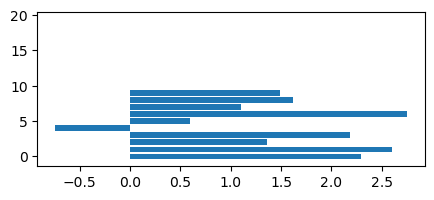

In [5]:
plt.figure(figsize=(5,2))
plt.barh([i for i in range(M)], beta)

100%|██████████| 1000/1000 [00:13<00:00, 75.61it/s]


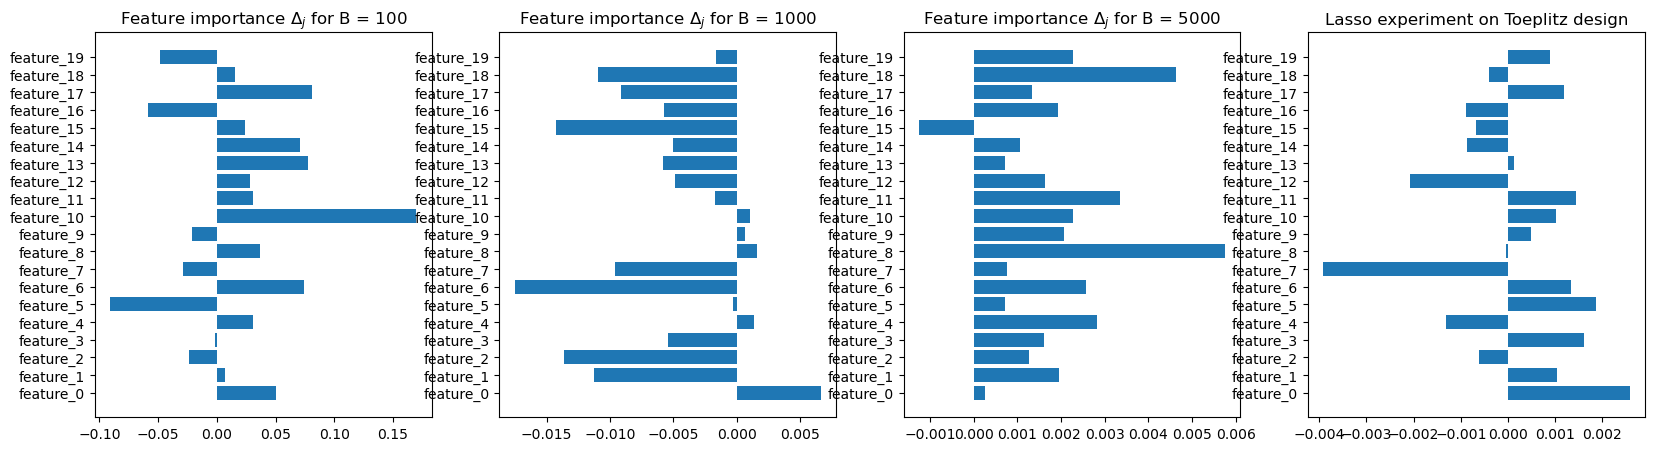

In [8]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    Delta = loco_error(X,y, model, x_ratio,list_B[b])
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.suptitle('Lasso experiment on Toeplitz design')
plt.savefig('./figures/mine_locomp_Lasso_SNR{}.svg'.format(SNR))

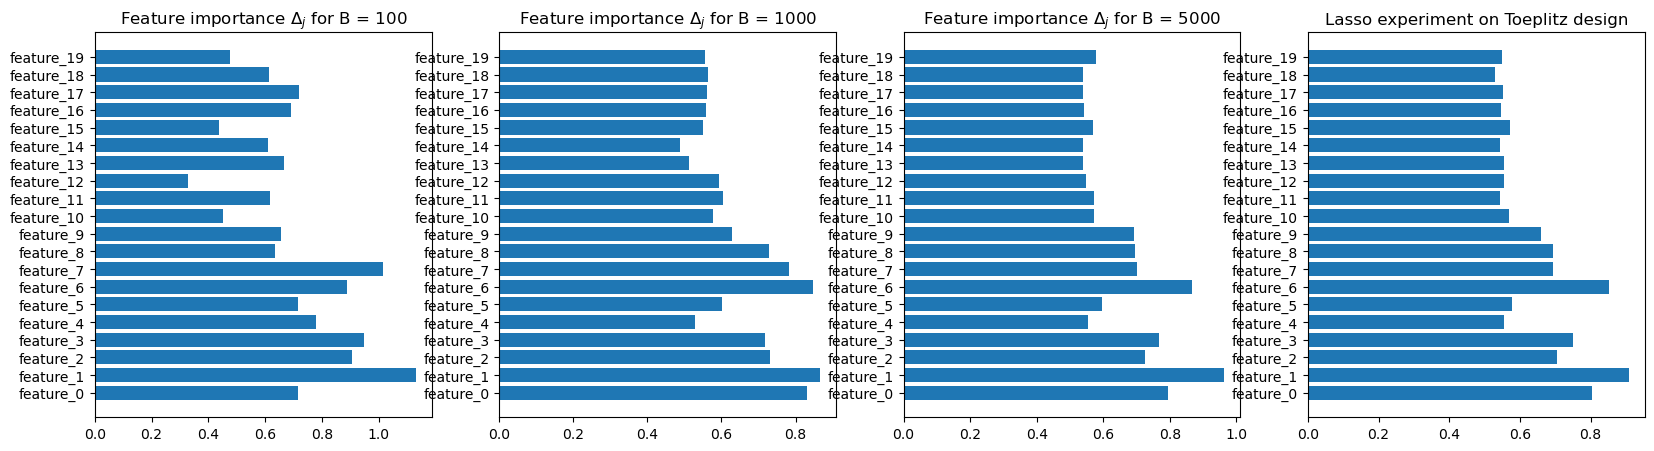

In [10]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/locomp_Lasso_SNR{}.svg'.format(SNR))

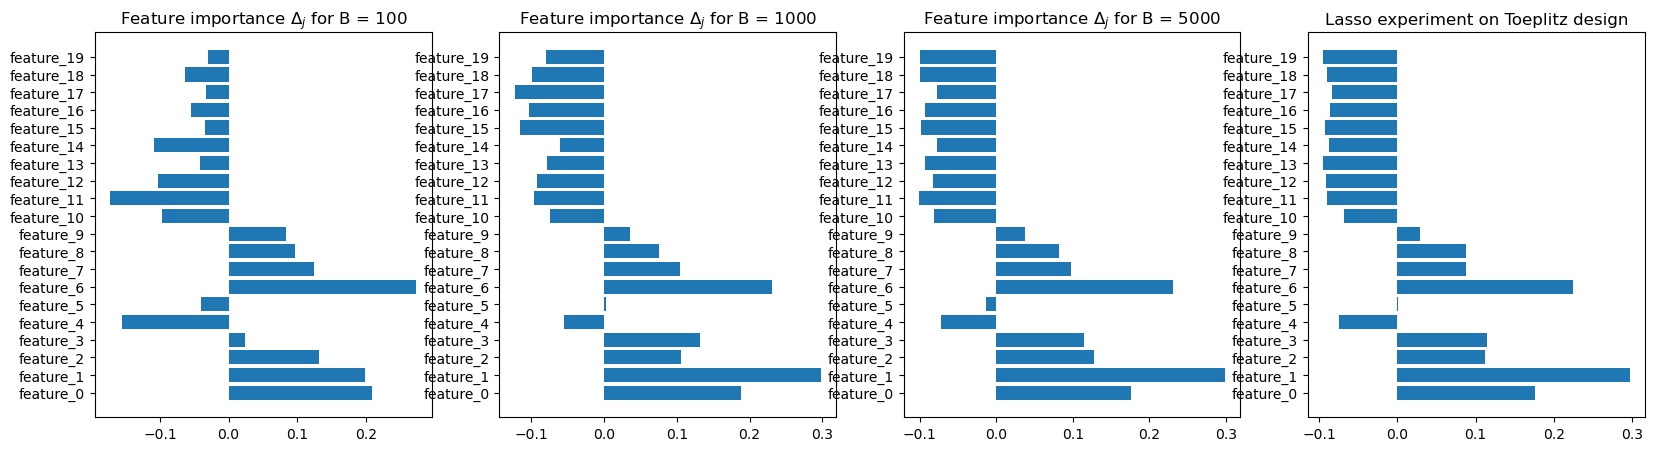

In [5]:
list_B = [100, 1000, 5000, 10000]
n_ratio = 0.2
m_ratio = 0.3
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMPReg(X,y,n_ratio, m_ratio,list_B[b], model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/og_locomp_Lasso_SNR{}.svg'.format(SNR))